In [1]:
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 통계검정
import scipy.stats as stats

#  분류 모델
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 분포
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

# 결측치처리
from sklearn.impute import SimpleImputer
#스케일링
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# 라벨인코더
from sklearn.preprocessing import LabelEncoder


/var/folders/m3/5c3zp5d91518bml26ndk894w0000gn/T/ipykernel_95758/2127322595.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 파일 불러오기 및 합치기

In [3]:
# 고객데이터
df=pd.read_csv('member_data.csv')
df

,회원번호,조합원상태,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member
0,1000012800,정상회원,수지구-풍덕천동,여,58.0,미신청,.,normal
1,1000103744,정상회원,처인구-고림동,여,34.0,미신청,.,normal
2,1000122304,정상회원,광주-기타,여,38.0,미신청,.,normal
3,1000163136,정상회원,수지구-동천동,여,73.0,미신청,.,normal
4,1000281920,정상회원,수지구-풍덕천동,여,42.0,신청,.,normal
...,...,...,...,...,...,...,...,...
11550,999682432,탈퇴,수지구-동천동,여,47.0,미신청,.,normal
11551,999721408,정상회원,수지구-동천동,여,43.0,미신청,.,normal
11552,999738112,정상회원,수지구-성복동,여,67.0,미신청,.,normal
11553,999754816,정상회원,수지구-상현동,여,44.0,신청,.,normal


In [4]:
# 판매데이터
df1=pd.read_csv('product_data_001.csv')
df2=pd.read_csv('product_data_002.csv')
df3=pd.read_csv('product_data_003.csv')
df4=pd.read_csv('product_data_004.csv')

In [5]:
result= pd.concat([df1,df2,df3,df4], join='inner')
result

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,반품_원거래일자,구매시각
0,2022-01-01,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),1.0,22207,매장C,NaN,10:04
1,2022-01-01,1476143616,정상회원,간식,빵,"식빵, 식사대용",아침빵(240g/8개)/매장,1.0,4403,매장C,NaN,10:09
2,2022-01-01,743192512,정상회원,채소,양념채소,생강,생강(300g),1.0,7083,매장C,NaN,10:12
3,2022-01-01,176912064,정상회원,축산물,유제품,우유/산양유,유기농저지방우유(종이팩/900ml),1.0,7849,매장C,NaN,10:23
4,2022-01-01,87592064,정상회원,양념/가루,가루,양념가루,카레(매운맛: 100g),3.0,15507,매장C,NaN,10:29
...,...,...,...,...,...,...,...,...,...,...,...,...
52565,2022-10-30,1110819712,정상회원,채소,뿌리채소,무,무(0.7~1kg미만),1.0,2680,매장A,NaN,13:26
52566,2022-10-30,1517953728,정상회원,채소,양념채소,쪽파,쪽파(500g),1.0,4212,매장A,NaN,10:58
52567,2022-10-30,713691392,정상회원,반찬,밑반찬,조림,우엉조림(반찬용/150g),1.0,7658,매장A,NaN,14:36
52568,2022-10-30,247926336,정상회원,간식,빵,건강곡물빵,감자바게트(180g)/매장,1.0,5169,매장A,NaN,16:23


- 고객데이터: df
- 판매데이터: result(각각의 데이터는 df1~df4)

## 시간대별 eda

/var/folders/m3/5c3zp5d91518bml26ndk894w0000gn/T/ipykernel_95758/3686341651.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result['구매시각'] = pd.to_datetime(result['구매시각'])  # 시간 형식으로 변환


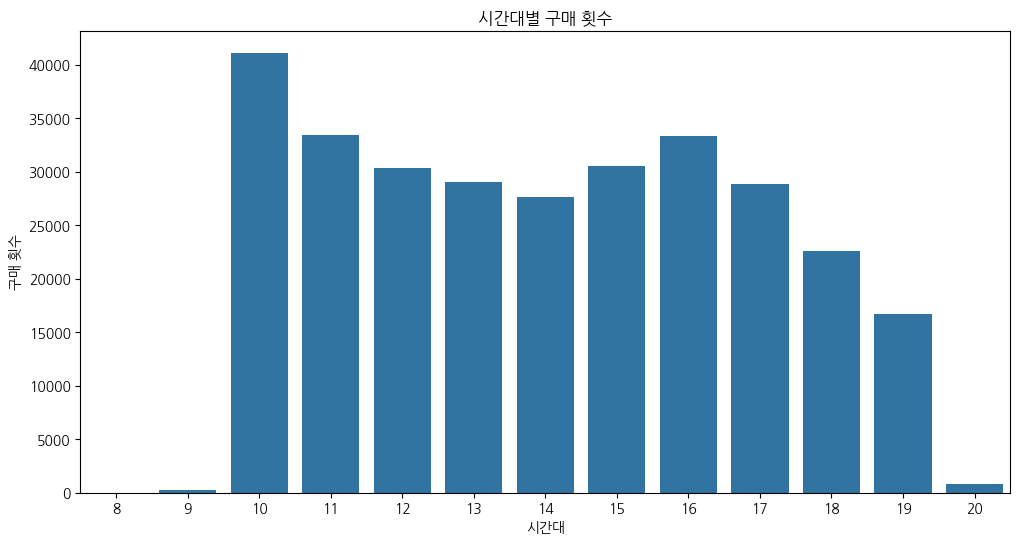

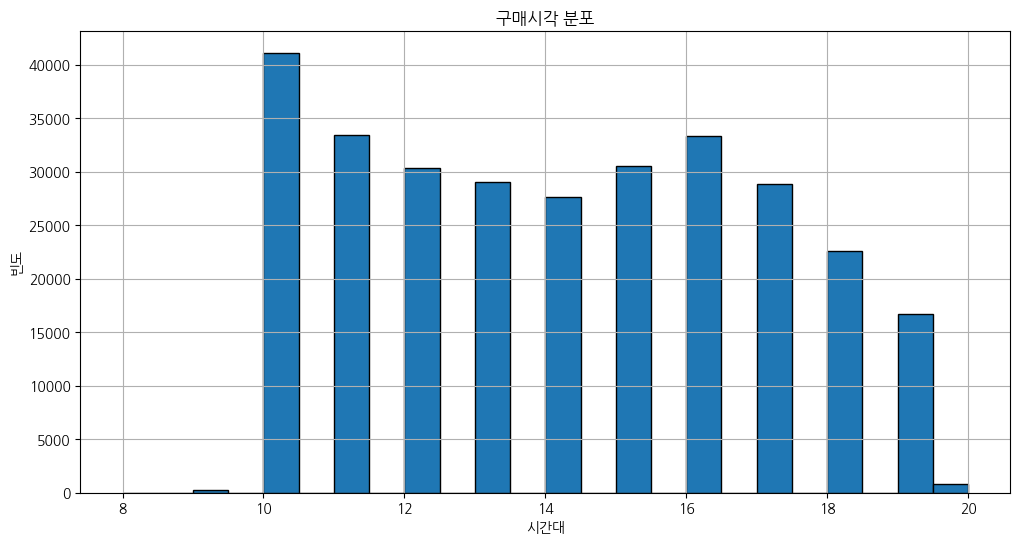

In [6]:
# '구매시각' 칼럼의 시계열 그래프
result['구매시각'] = pd.to_datetime(result['구매시각'])  # 시간 형식으로 변환
result['Hour'] = result['구매시각'].dt.hour  # 시간대를 추출하여 새로운 칼럼 생성

# 시간대별 구매 횟수 시각화
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=result)
plt.title('시간대별 구매 횟수')
plt.xlabel('시간대')
plt.ylabel('구매 횟수')
plt.show()

# '구매시각' 칼럼의 히스토그램
plt.figure(figsize=(12, 6))
result['Hour'].hist(bins=24, edgecolor='black')
plt.title('구매시각 분포')
plt.xlabel('시간대')
plt.ylabel('빈도')
plt.show()

## 연령 분포 eda

In [9]:
a=df[df['성별']=='여']

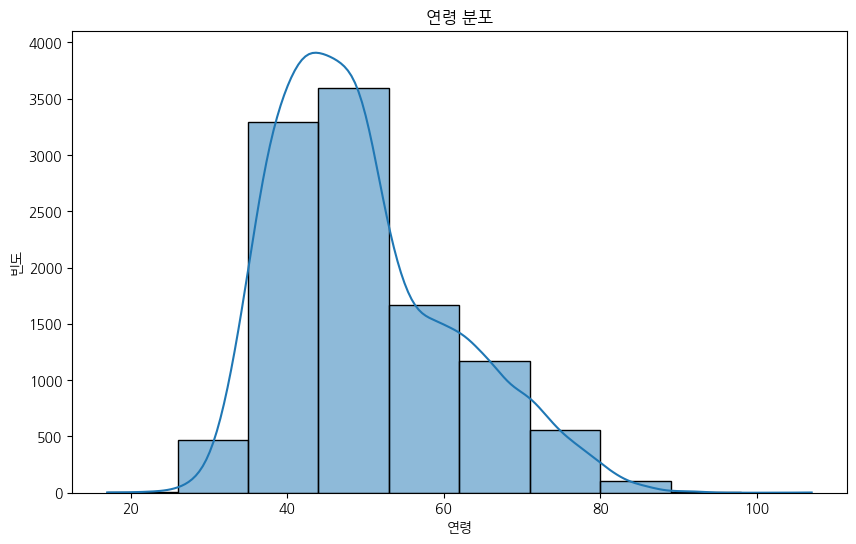

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(a['연령'], bins=10, kde=True)
plt.title('연령 분포')
plt.xlabel('연령')
plt.ylabel('빈도')
plt.show()